# Importar librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from pycaret.regression import setup
import statsmodels.api as sm

# Funciones auxiliares

In [2]:
def matriz_correlacion(dataset, target):
    corr_matrix = dataset.corr()
    corr_matrix[target].sort_values(ascending=False)
    #from matplotlib.colors import ListedColormap
    #cm_blue_orange = ListedColormap(['tab:blue', 'orange'])
    cm_red_blue = mpl.colormaps['RdBu']
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    f, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap=cm_red_blue, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Heatmap con Valores Numéricos y Colores')
    # Mostrar el gráfico
    plt.show()

In [3]:
# Calcular el VIF para cada característica
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

In [4]:
# # Función para entrenar y evaluar un modelo
# def train_evaluate_model(model, X_train, X_test, y_train, y_test):
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Calcular RMSE
#     r2 = r2_score(y_test, y_pred)
#     return rmse, r2

In [5]:
# Función para entrenar y evaluar el modelo
def train_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)
    
    return rmse_train, r2_train, rmse_test, r2_test

In [6]:
'''eliminación_hacia_atras https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLSResults.html

dataset: datos a entrenar (dataframe)
level_significance: nivel de significancia, por default 0.05

Este método hace la eliminación hacia atrás de la regresión lineal múltiple de acuerdo a un nivel de significancia (p valor)
utilizando como métrica al valor r cuadrado ajustado.
Return: Arroja una lista de los nombres de las variables más significativas para el modelo'''
def eliminacion_hacia_atras(dataset:pd.DataFrame, target:str, level_significance = 0.05):
    X = dataset.loc[:, (dataset.columns != target)]
    y = dataset.loc[:, target]
    columnas_X = X.columns.tolist()
    
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=123)
    X_train = pd.DataFrame(X_train, columns=X.columns)  # Reconstruir DataFrame para entrenamiento
    y_train = pd.Series(y_train)
    y_train.name = target

    #preparar los predictores para función OLS
    #Se agrega una columna de '1' (constante) al inicio a los predictores para el método OLS (obligatorio)
    X_OLS = sm.add_constant(X_train)
    y_OLS = y_train
    
    rsquared_adj_dictionary = {} #clave: r cuadrado ajustado, valor: nombre de las variable independiente

    while len(columnas_X) > 0:
        regression_OLS = sm.OLS(endog = y_OLS, exog = X_OLS).fit()
        
        pvalues = regression_OLS.pvalues.iloc[1:] #Se tiene los p valores del modelo // No se escoge la columna llena de 1 (constante)
        max_p_value = max(pvalues) #el mayor p valor
        model_rsquared_adj = regression_OLS.rsquared_adj # r2 ajustado del modelo

        feature_to_remove = pvalues.idxmax() #nombre de la variable a eliminar (p valor max)
        rsquared_adj_dictionary[model_rsquared_adj] = columnas_X.copy()

        #Print de los resultados estadísticos (opcional - se puede comentar)
        print('*'*80)
        print(regression_OLS.summary(), end= '\n'*2)
        print('Criterio de Información de Akaike (AIC), debe ser preferiblemente el menor entre todos los modelos:', regression_OLS.aic)
        print(rsquared_adj_dictionary[model_rsquared_adj])
        print('*'*80, end= '\n'*4)
        #Print de los resultados estadísticos (opcional - se puede comentar)

        if max_p_value > level_significance:

            X_OLS = X_OLS.drop(columns=[feature_to_remove])
            columnas_X.remove(feature_to_remove)
        else: #si ya se superó el umbral de significancia se para el ciclo while
            break

    maximo_r2_adj = max(rsquared_adj_dictionary)

    #Print de los resultados (opcional - se puede comentar)
    print('//ESTE ES EL MEJOR MODELO')
    print(f"R^2: {maximo_r2_adj}, variables de este modelo: {rsquared_adj_dictionary[maximo_r2_adj]}")
    #Print de los resultados (opcional - se puede comentar)

    return rsquared_adj_dictionary[maximo_r2_adj] + [target]

# Preprocesamiento

In [7]:
average_cluster_2=pd.read_csv("../data/interim/average_series_cluster_2.csv",parse_dates=["Date/Time"])



In [8]:
average_cluster_2.drop(columns="Heating:Electricity [kW](Hourly)",inplace=True)

In [9]:
average_cluster_2.shape

(8783, 6)

In [10]:
average_cluster_2.head()

,Date/Time,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly)
0,2004-01-01 01:00:00,741.819628,96.624617,313.143988,34.961655,113.31278
1,2004-01-01 02:00:00,713.118211,96.624617,280.018781,34.961655,113.31278
2,2004-01-01 03:00:00,717.589655,96.624617,285.007840,34.961655,113.31278
3,2004-01-01 04:00:00,728.879268,96.624617,296.254281,34.961655,113.31278
4,2004-01-01 05:00:00,740.140483,96.624617,299.639968,44.493766,113.31278


In [11]:
average_cluster_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 6 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Date/Time                                   8783 non-null   datetime64[ns]
 1   Electricity:Facility [kW](Hourly)           8395 non-null   float64       
 2   Fans:Electricity [kW](Hourly)               8395 non-null   float64       
 3   Cooling:Electricity [kW](Hourly)            8395 non-null   float64       
 4   InteriorLights:Electricity [kW](Hourly)     8395 non-null   float64       
 5   InteriorEquipment:Electricity [kW](Hourly)  8395 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 411.8 KB


In [12]:
average_cluster_2.isna().sum()

Date/Time                                       0
Electricity:Facility [kW](Hourly)             388
Fans:Electricity [kW](Hourly)                 388
Cooling:Electricity [kW](Hourly)              388
InteriorLights:Electricity [kW](Hourly)       388
InteriorEquipment:Electricity [kW](Hourly)    388
dtype: int64

In [13]:
# Imputar o eliminar valores faltantes si existen
average_cluster_2.fillna(method='ffill', inplace=True)

In [14]:
average_cluster_2.isna().sum()

Date/Time                                     0
Electricity:Facility [kW](Hourly)             0
Fans:Electricity [kW](Hourly)                 0
Cooling:Electricity [kW](Hourly)              0
InteriorLights:Electricity [kW](Hourly)       0
InteriorEquipment:Electricity [kW](Hourly)    0
dtype: int64

In [15]:
# Establecer la columna de fecha como índice
average_cluster_2.set_index('Date/Time', inplace=True)

In [16]:
# Extraer características temporales
average_cluster_2['hour'] = average_cluster_2.index.hour
average_cluster_2['day_of_week'] = average_cluster_2.index.dayofweek
average_cluster_2['month'] = average_cluster_2.index.month

In [17]:
average_cluster_2.head()

,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),hour,day_of_week,month
Date/Time,,,,,,,,
2004-01-01 01:00:00,741.819628,96.624617,313.143988,34.961655,113.31278,1,3,1
2004-01-01 02:00:00,713.118211,96.624617,280.018781,34.961655,113.31278,2,3,1
2004-01-01 03:00:00,717.589655,96.624617,285.007840,34.961655,113.31278,3,3,1
2004-01-01 04:00:00,728.879268,96.624617,296.254281,34.961655,113.31278,4,3,1
2004-01-01 05:00:00,740.140483,96.624617,299.639968,44.493766,113.31278,5,3,1


In [18]:
average_cluster_2.columns

Index(['Electricity:Facility [kW](Hourly)', 'Fans:Electricity [kW](Hourly)',
       'Cooling:Electricity [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)', 'hour', 'day_of_week',
       'month'],
      dtype='object')

In [19]:
target='Electricity:Facility [kW](Hourly)'

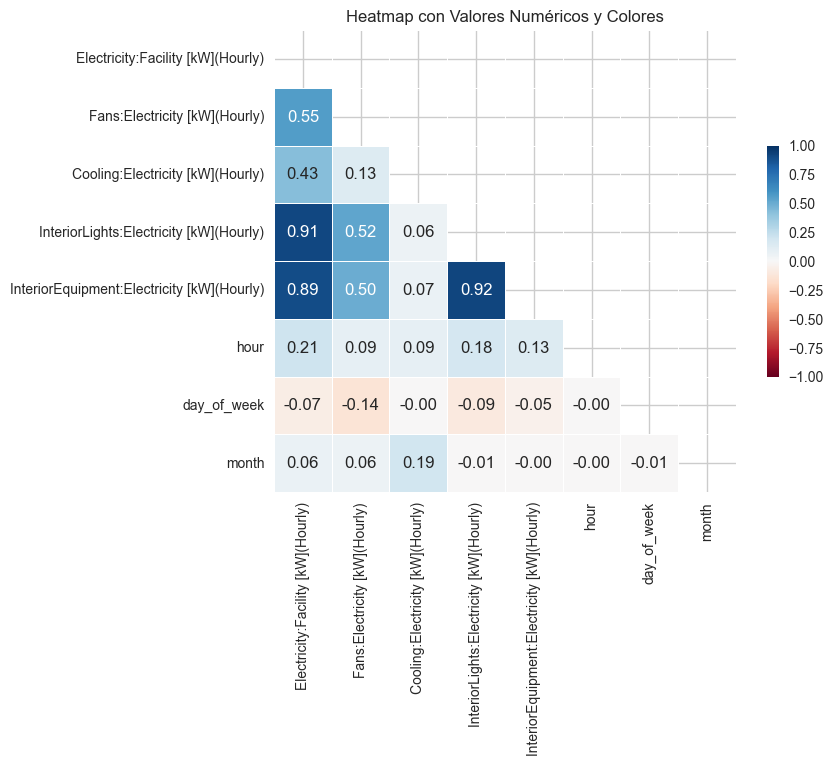

In [20]:
matriz_correlacion(average_cluster_2, target)

In [21]:
dataset_sin_correlacion = average_cluster_2.copy()
multicollinearity_threshold = 0.6 #definir umbral para eliminar las variables altamente correlacionadas entre sí 
sin_correlacion = setup(data = dataset_sin_correlacion, target = target, remove_multicollinearity = True, multicollinearity_threshold = multicollinearity_threshold) #se eliminan los valores con correlación mayor a "multicollinearity_threshold"

,Description,Value
0,Session id,8521
1,Target,Electricity:Facility [kW](Hourly)
2,Target type,Regression
3,Original data shape,"(8783, 8)"
4,Transformed data shape,"(8783, 7)"
5,Transformed train set shape,"(6148, 7)"
6,Transformed test set shape,"(2635, 7)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


In [22]:
lista_sin_correlacion = sin_correlacion.dataset_transformed.columns.to_list()
lista_sin_correlacion

['FansElectricity kW(Hourly)',
 'CoolingElectricity kW(Hourly)',
 'InteriorLightsElectricity kW(Hourly)',
 'hour',
 'day_of_week',
 'month',
 'Electricity:Facility [kW](Hourly)']

In [23]:
lista_sin_correlacion_p=["Electricity:Facility [kW](Hourly)",'Fans:Electricity [kW](Hourly)','InteriorLights:Electricity [kW](Hourly)','Cooling:Electricity [kW](Hourly)', 'hour', 'day_of_week',
       'month']

In [24]:
dataset_sin_correlacion = dataset_sin_correlacion.loc[:,lista_sin_correlacion_p]

In [25]:
dataset_sin_correlacion.head()

,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),hour,day_of_week,month
Date/Time,,,,,,,
2004-01-01 01:00:00,741.819628,96.624617,34.961655,313.143988,1,3,1
2004-01-01 02:00:00,713.118211,96.624617,34.961655,280.018781,2,3,1
2004-01-01 03:00:00,717.589655,96.624617,34.961655,285.007840,3,3,1
2004-01-01 04:00:00,728.879268,96.624617,34.961655,296.254281,4,3,1
2004-01-01 05:00:00,740.140483,96.624617,44.493766,299.639968,5,3,1


In [26]:
features_corr=dataset_sin_correlacion.drop(columns='Electricity:Facility [kW](Hourly)').copy()

**Evaluación de la Multicolinealidad**

* La multicolinealidad ocurre cuando dos o más variables están altamente correlacionadas entre sí.

* Esto puede causar problemas en los modelos de regresión porque dificulta determinar el efecto individual de cada variable.
  
**¿Cómo evaluamos la multicolinealidad?**

* Usamos el Factor de Inflación de la Varianza (VIF). Un VIF alto (mayor a 10) indica multicolinealidad alta.

* Eliminamos las variables con VIF mayor a 10 para reducir la multicolinealidad y simplificar nuestro modelo.

In [27]:
# Paso 3: Evaluación de la Multicolinealidad
vif_before_corr = calculate_vif(features_corr)
vif_before_corr

,feature,VIF
0,Fans:Electricity [kW](Hourly),27.366974
1,InteriorLights:Electricity [kW](Hourly),4.275284
2,Cooling:Electricity [kW](Hourly),19.635014
3,hour,3.872300
4,day_of_week,3.149328
5,month,4.740029


In [28]:
features_selected_corr=features_corr.copy()
features_selected_corr.head()


,Fans:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),hour,day_of_week,month
Date/Time,,,,,,
2004-01-01 01:00:00,96.624617,34.961655,313.143988,1,3,1
2004-01-01 02:00:00,96.624617,34.961655,280.018781,2,3,1
2004-01-01 03:00:00,96.624617,34.961655,285.007840,3,3,1
2004-01-01 04:00:00,96.624617,34.961655,296.254281,4,3,1
2004-01-01 05:00:00,96.624617,44.493766,299.639968,5,3,1


In [29]:
taget_predict=dataset_sin_correlacion.loc[:,'Electricity:Facility [kW](Hourly)'].copy()

In [30]:
lista_eliminicacion_hacia_atras = eliminacion_hacia_atras(dataset_sin_correlacion,target)

********************************************************************************
                                    OLS Regression Results                                   
Dep. Variable:     Electricity:Facility [kW](Hourly)   R-squared:                       0.970
Model:                                           OLS   Adj. R-squared:                  0.970
Method:                                Least Squares   F-statistic:                 3.798e+04
Date:                               Sat, 10 Aug 2024   Prob (F-statistic):               0.00
Time:                                       12:36:39   Log-Likelihood:                -35949.
No. Observations:                               7026   AIC:                         7.191e+04
Df Residuals:                                   7019   BIC:                         7.196e+04
Df Model:                                          6                                         
Covariance Type:                           nonrobust                     

In [31]:
lista_eliminicacion_hacia_atras

['Fans:Electricity [kW](Hourly)',
 'InteriorLights:Electricity [kW](Hourly)',
 'Cooling:Electricity [kW](Hourly)',
 'hour',
 'day_of_week',
 'month',
 'Electricity:Facility [kW](Hourly)']

In [32]:
lista_sin_correlacion_p=['Fans:Electricity [kW](Hourly)','InteriorLights:Electricity [kW](Hourly)','Cooling:Electricity [kW](Hourly)', 'hour', 'day_of_week',
       'month']

In [33]:
features_predict=average_cluster_2.loc[:,lista_sin_correlacion_p].copy()

In [34]:
taget_predict=dataset_sin_correlacion.loc[:,'Electricity:Facility [kW](Hourly)'].copy()

# Seleccion del modelo

In [35]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(features_predict, taget_predict, test_size=0.2, random_state=42)

In [36]:
# Escalar las características
scaler_corr = StandardScaler()
X_train_scaled_corr = scaler_corr.fit_transform(X_train_corr)
X_test_scaled_corr = scaler_corr.transform(X_test_corr)

In [38]:
# Definición de modelos
models = {
    "Linear Regression": LinearRegression(),
    "Stepwise Linear Regression": Lasso(alpha=0.01),  # Utilizando Lasso como aproximación a la regresión paso a paso
    "Tree": DecisionTreeRegressor(),
    "SVM": SVR(kernel='rbf'),
    "Efficient Linear": LinearRegression(),  # Utilizando Linear Regression como proxy
    "Ensemble": VotingRegressor(estimators=[
        ('lr', LinearRegression()),
        ('dt', DecisionTreeRegressor()),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# Variables para almacenar resultados y modelos entrenados
results = {}
trained_models = {}

# Entrenar y evaluar cada modelo
for model_name, model in models.items():
    rmse_train, r2_train, rmse_test, r2_test = train_evaluate_model(model, X_train_scaled_corr, X_test_scaled_corr, y_train_corr, y_test_corr)
    results[model_name] = {
        'RMSE Train': rmse_train, 
        'R2 Train': r2_train,
        'RMSE Test': rmse_test, 
        'R2 Test': r2_test
    }
    # Guardar el modelo entrenado en el diccionario
    trained_models[model_name] = model

In [39]:
# Convertir a DataFrame y verificar overfitting
df_overfitting_results= pd.DataFrame(results)
df_overfitting_results.head()

,Linear Regression,Stepwise Linear Regression,Tree,SVM,Efficient Linear,Ensemble,Random Forest
RMSE Train,40.151807,40.151813,3.588435e-15,65.825167,40.151807,13.830281,4.259597
R2 Train,0.970276,0.970276,1.000000e+00,0.920112,0.970276,0.996473,0.999665
RMSE Test,39.529324,39.530181,1.509691e+01,71.865033,39.529324,17.062463,11.080511
R2 Test,0.972366,0.972365,9.959693e-01,0.908665,0.972366,0.994851,0.997829


# Mejorar hiperparametros

In [71]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3,  # Validación cruzada de 3 pliegues
                           n_jobs=-1,  # Usar todos los núcleos disponibles
                           scoring='neg_root_mean_squared_error',  # Usar RMSE
                           verbose=2)

# Realizar la búsqueda en cuadrícula
grid_search.fit(X_train_scaled_corr, y_train_corr)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_

Fitting 3 folds for each of 216 candidates, totalling 648 fits


In [72]:
print("Mejores hiperparámetros:", best_params)

{'bootstrap': True,
 'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [73]:
# Entrenar el modelo con los mejores hiperparámetros
optimized_rf_model = RandomForestRegressor(**best_params, random_state=42)
optimized_rf_model.fit(X_train_scaled_corr, y_train_corr)

# Evaluar el modelo optimizado
rmse_train_opt = np.sqrt(mean_squared_error(y_train_corr, optimized_rf_model.predict(X_train_scaled_corr)))
r2_train_opt = r2_score(y_train_corr, optimized_rf_model.predict(X_train_scaled_corr))

rmse_test_opt = np.sqrt(mean_squared_error(y_test_corr, optimized_rf_model.predict(X_test_scaled_corr)))
r2_test_opt = r2_score(y_test_corr, optimized_rf_model.predict(X_test_scaled_corr))

# Resultados
optimized_rf_results = {
    "Optimized Random Forest": {
        'RMSE Train': rmse_train_opt,
        'R2 Train': r2_train_opt,
        'RMSE Test': rmse_test_opt,
        'R2 Test': r2_test_opt
    }
}

In [74]:
# Mostrar los resultados
print("Resultados del modelo Random Forest optimizado:")
optimized_rf_results_df=pd.DataFrame(optimized_rf_results)
optimized_rf_results_df

,Optimized Random Forest
MSE Test,122.930658
MSE Train,17.654442
R2 Test,0.997826
R2 Train,0.999675
